In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# X: original img; K: kernel
def corr2d(X, K): #@save
    h, w = K.shape
    Y = torch.zeros((X.shape[0]-h+1, X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[.0, 1., 2.], [3., 4., 5.], [6., 7., 8.]])
K = torch.tensor([[0., 1.], [2., 3.]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 6.2.2 Convolutional Layers

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 6.2.3 Object Edge Detection in Images

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
# kernel of size 1 x 2
K = torch.tensor([[1., -1.]])

In [7]:
# cross correlation
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
# but it can't detect horizontal edges
print(corr2d(X.t(), K), "\nX: \n", X)
print(X.reshape((1, 1)+X.shape))

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]) 
X: 
 tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]])


### 6.2.4 Learning a Kernel


In [9]:
# construct a two-dimentional convolutional layer with 1 output channel and a kernel of shape (1, 2). (ignore bias here)
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1, 2), bias=False)
# the two-dimentional convolutional layer uses four-dimentional input and output in the format of (example, channel, height, width), where the batch size and number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
learning_rate = 3e-2
for i in range(10):
    Y_hat = conv2d(X)
    loss_mat = (Y_hat-Y)**2
    # clear grad before back prop
    conv2d.zero_grad()
    loss_mat.sum().backward()
    # update kernel
    conv2d.weight.data[:] -= learning_rate * conv2d.weight.grad
    if (i+1)%2 == 0:
        print(f'batch {i+1}, loss {loss_mat.sum(): .3f}')

batch 2, loss  4.563
batch 4, loss  0.772
batch 6, loss  0.132
batch 8, loss  0.023
batch 10, loss  0.004


In [10]:
conv2d.weight.data

tensor([[[[ 0.9918, -0.9860]]]])

In [11]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9918, -0.9860]])

## 6.3 Padding and Stride

### 6.3.1 Padding

In [12]:
import torch
from torch import nn

In [13]:
# we define a convenience function to calculate the convolutional layer. this function initializes the convolutional layer weights and performs corresponding dimensionality elevations and redcutions on the input and output
def comp_conv2d(conv2d, X):
    # here (1, 1) indicates that batch size and number of channels are both 1, so make it a (1, 1, shape[0], shape[1]) dimention
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # exclude first two dimenstions that don't interest us: examples and channels
    return Y.reshape(Y.shape[2:])
# note: 1 row or column is padded on either side, so a total of 2 rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d=conv2d, X=X).shape

torch.Size([8, 8])

In [14]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 6.3.2 Stride

In [15]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [16]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 6.4 Multiple Input and Multiple Output Channels
### 6.4.1. Multiple Input Channels

In [17]:
import torch 
from d2l import torch as d2l
def corr2d_multi_in(X, K):
    # first, iterate through the 0th dimenstion (channel dimension) of 'X' and 'K', then add them together
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [18]:
temp = torch.tensor(list(range(9))).reshape(3, 3)
X = torch.stack((temp, temp+1))
temp = torch.tensor(list(range(4))).reshape(2, 2)
K = torch.stack((temp, temp+1))
X, K

(tensor([[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]],
 
         [[1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]]]),
 tensor([[[0, 1],
          [2, 3]],
 
         [[1, 2],
          [3, 4]]]))

In [19]:
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [20]:
### 6.4.2. Multiple Output Channels

In [21]:
def corr2d_multi_in_out(X, K):
    # iterate through the 0th dimension of K and each time, perform cross correlation opearations with input X. all of the values are stacked toghther
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [22]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [23]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [24]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # matrix multiplication in the fully-connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [25]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
Y1, Y2

(tensor([[[-1.4305,  0.7112, -0.5670],
          [-0.7587,  0.4894,  0.1875],
          [-0.4913, -2.5045,  0.3877]],
 
         [[ 1.1119, -0.4571, -0.7338],
          [ 0.8798, -0.9313, -1.0345],
          [ 0.5885,  4.3161,  0.0705]]]),
 tensor([[[-1.4305,  0.7112, -0.5670],
          [-0.7587,  0.4894,  0.1875],
          [-0.4913, -2.5045,  0.3877]],
 
         [[ 1.1119, -0.4571, -0.7338],
          [ 0.8798, -0.9313, -1.0345],
          [ 0.5885,  4.3161,  0.0705]]]))

## 6.5. Pooling
### 6.5.1. Maximum Pooling and Average Pooling

In [26]:
import torch
from torch import nn
from d2l import torch as d2l
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == 'avg':
                # need to convert Long to float to calculate mean
                Y[i, j] = (1. *X[i:i+p_h, j:j+p_w]).mean()
    return Y

In [27]:
X = torch.tensor(list(range(9))).reshape((3, 3))
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [28]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 6.5.2. Padding and Stride

In [29]:
X = torch.arange(16, dtype=torch.float32).reshape(1, 1, 4, 4)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [30]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### Multiple Channels

In [32]:
X = torch.cat((X, X+1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [33]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 6.6. Convolutional Neural Networks (LeNet)

In [34]:
import torch 
from torch import nn
from d2l import torch as d2l
class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
net = nn.Sequential(Reshape(), 
                    nn.Conv2d(1, 6, kernel_size=5, padding=2),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16*5*5, 120), 
                    nn.Sigmoid(),
                    nn.Linear(120, 84),
                    nn.Sigmoid(), 
                    nn.Linear(84, 10))

In [35]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [36]:
batch_size = 16
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [38]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """compute the accuracy for a model on a dataset using a GPU"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    # number of correct predictions, number of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # required for BERT Fine-tuning?
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [41]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """train a model with a GPU (defined in chapter 6)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train accuracy', 'test accuracy'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # sum of training loss, sum of training accuracy, number of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_accuracy = metric[1]/metric[2]
            if (i+1)%(num_batches//5) == 0 or i == num_batches-1:
                animator.add(epoch+(i+1)/num_batches, (train_loss, train_accuracy, None))
        test_accuracy = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_accuracy))
    print(f'loss {train_loss:.3f}, train accuracy {train_accuracy:.3f}, '
          f'test accuracy {test_accuracy:.3f}')
    print(f'{metric[2]*num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.277, train accuracy 0.896, test accuracy 0.873
3390.9 examples/secon cpu


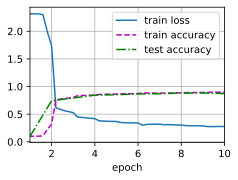

In [42]:
lr, num_epochs = .9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())